**Projet Traitement du Langage Naturel**

*Préambule : le projet est à faire par groupe de deux personnes.*



Le projet porte cette année sur le traitement du langage naturel. Je vous donne le choix entre deux sujets :



*   **Génération** : vous devez implémenter un modèle permettant de générer du texte ressemblant à la base de données qui vous est fournie. En l'occurence, il s'agit ici de tweets écrits par Donald Trump.
*   **Classification** : vous devez implémenter un modèle permettant de classifier des titres d'articles de presse, comme étant ou pas du *clickbait*.

Je vous autorise à traiter un autre sujet si vous le souhaitez, mais **VOUS DEVEZ ME LE FAIRE VALIDER D'ABORD**.


Voici une liste des tâches que je m'attends à vous voir réaliser pour mener à bien votre projet :     

*   Lecture de la Base de Données et Chargement dans un notebook
*   Mise en forme (*Tokenization*) de la base de données : ici vous pouvez opter dans un premier temps pour une solution simple (caractères ou mots), puis dans un second temps vous pouvez tester des solutions plus compliquées (voir par exemple [ici](https://huggingface.co/learn/nlp-course/chapter2/4)
*   Implémentation du modèle, en vous inspirant du TP que nous avons fait ensemble. Attention à choisir le bon type de modèle (famille BERT ou GPT)
*   Entraînement et évaluation du modèle.

Chacune de ces étapes devra être décrite dans un rapport de 15 pages maximum, que vous me rendrez avec un Notebook correspondant.






**Projet GENERATION : Base de données de tweets de Trump** :

In [1]:
import tensorflow as tf
import csv

path_to_file = tf.keras.utils.get_file('realdonaltrump.csv', 'https://drive.google.com/uc?export=download&id=1s1isv9TQjGiEr2gG__8bOdBFvQlmepRt')


tweets = []
with open(path_to_file, newline='') as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        tweets.append(row['content'])

# Affichage des 10 premiers tweets
print(tweets[:10])

11331653/11331653 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
['Be sure to tune in and watch Donald Trump on Late Night with David Letterman as he presents the Top Ten List tonight!', 'Donald Trump will be appearing on The View tomorrow morning to discuss Celebrity Apprentice and his new book Think Like A Champion!', 'Donald Trump reads Top Ten Financial Tips on Late Show with David Letterman: http://tinyurl.com/ooafwn - Very funny!', 'New Blog Post: Celebrity Apprentice Finale and Lessons Learned Along the Way: http://tinyurl.com/qlux5e', '"My persona will never be that of a wallflower - I’d rather build walls than cling to them" --Donald J. Trump', 'Miss USA Tara Conner will not be fired - "I\'ve always been a believer in second chances." says Donald Trump', 'Listen to an interview with Donald Trump discussing his new book, Think Like A Champion: http://tinyurl.com/qs24vl', '"Strive for wholeness and keep your sense of wonder intact." --Donald J. Trump http://tinyurl.com/pqpfvm', 'Enter the "Th

#Projet GENERATION :


In [2]:
! pip install tiktoken
! pip install torchinfo
! pip install transformers datasets
! pip install nltk

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 18.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 18.9 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.5.1+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible

In [3]:
import tiktoken
import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import re
import numpy as np
from torchinfo import summary
from tqdm import tqdm
import os

In [4]:
batch_size = 30
context_size = 512
epochs = 150
eval_interval = 500
learning_rate = 1e-4
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)
n_embd = 150
n_head = 3
n_layer = 3
dropout = 0.2

cuda


In [129]:
# Fonction de nettoyage des données
# Cette fonction parcourt chaque tweet et filtre ceux qui ne correspondent pas à
# un format spécifique, uniquement constitué de caractères alphanumériques et de quelques symboles autorisés.
def datacleaning(tweets) :
  filtered_tweets = []
  for tweet in tweets:
    if re.fullmatch(r'[a-zA-Z0-9\s.,!?\'"-]+', tweet):
      filtered_tweets.append(tweet)
  return filtered_tweets


In [130]:
tweets = datacleaning(tweets)
print(tweets[:10])

['Be sure to tune in and watch Donald Trump on Late Night with David Letterman as he presents the Top Ten List tonight!', 'Donald Trump will be appearing on The View tomorrow morning to discuss Celebrity Apprentice and his new book Think Like A Champion!', 'Miss USA Tara Conner will not be fired - "I\'ve always been a believer in second chances." says Donald Trump', "Here's to a safe and happy Independence Day for one and all - Enjoy it! --Donald J. Trump", 'Wishing you and yours a very Happy and Bountiful Thanksgiving!', 'Superbowl Sunday is a great American tradition. The Colts and Saints are already champions, but may the best team win!', 'The Celebrity Apprentice has a two-hour premiere this Sunday, March 14th, at 9 p.m. on NBC. This will be the best season yet, see you then!', 'The new season of the Celebrity Apprentice is off to a great start-- last night it swept the 10 p.m. hour in every key demographic.', "Olympic Gold Medalist Evan Lysacek just left my office. He is in town a

In [7]:
# Fonction de création de vocabulaire
# Cette fonction prend un jeu de données
# et crée un vocabulaire unique de tous les caractères présents dans les données.
# Elle ajoute également des tokens spéciaux <sot> (start of tweet) et <eot> (end of tweet).
def vocab_creation(base) :
  all_words = ''
  for s in base:
    all_words = all_words + s

  vocab =  sorted(list(set(all_words)))
  vocab.insert(0,'<sot>')
  vocab.append('<eot>')
  token_to_id = {char: idx for idx, char in enumerate(vocab)}
  id_to_token = {idx: char for idx, char in enumerate(vocab)}
  return len(vocab), token_to_id,id_to_token

In [8]:
VOCAB_SIZE,token_to_id,id_to_token = vocab_creation(tweets)
print("".join(token_to_id.keys()))
print(VOCAB_SIZE)
print(token_to_id)

<sot> !"',-.0123456789?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz<eot>
72
{'<sot>': 0, ' ': 1, '!': 2, '"': 3, "'": 4, ',': 5, '-': 6, '.': 7, '0': 8, '1': 9, '2': 10, '3': 11, '4': 12, '5': 13, '6': 14, '7': 15, '8': 16, '9': 17, '?': 18, 'A': 19, 'B': 20, 'C': 21, 'D': 22, 'E': 23, 'F': 24, 'G': 25, 'H': 26, 'I': 27, 'J': 28, 'K': 29, 'L': 30, 'M': 31, 'N': 32, 'O': 33, 'P': 34, 'Q': 35, 'R': 36, 'S': 37, 'T': 38, 'U': 39, 'V': 40, 'W': 41, 'X': 42, 'Y': 43, 'Z': 44, 'a': 45, 'b': 46, 'c': 47, 'd': 48, 'e': 49, 'f': 50, 'g': 51, 'h': 52, 'i': 53, 'j': 54, 'k': 55, 'l': 56, 'm': 57, 'n': 58, 'o': 59, 'p': 60, 'q': 61, 'r': 62, 's': 63, 't': 64, 'u': 65, 'v': 66, 'w': 67, 'x': 68, 'y': 69, 'z': 70, '<eot>': 71}


In [9]:
# Fonction pour encoder une chaîne de caractères en indices numériques
encode  = lambda s :[token_to_id[c] for c in s]
# Fonction pour décoder une liste d'indices en chaîne de caractères
decode  = lambda l : ''.join([id_to_token[i] for i in l])

In [10]:
encode("trump")

[64, 62, 65, 57, 60]

In [11]:
# Cette fonction prend une liste de chaînes de caractères ('base') et un dictionnaire de mappage de tokens ('token_to_id'),
# elle encode chaque chaîne en une séquence d'indices numériques correspondant à chaque token y compris les tokens de début et de fin,
# puis retourne les données sous forme de tenseur PyTorch et les indices des positions de <sot>.
def data_preprocessing(base,token_to_id) :
  n = len(base)
  code = []
  for s in base :
    s = [token_to_id['<sot>']] + encode(s) + [token_to_id['<eot>']]
    code.extend(s)
  data = np.asarray(code)
  indices = np.where(data==0)[0]
  return torch.from_numpy(data),indices.astype(int)


In [12]:
data, indices = data_preprocessing(tweets,token_to_id)


In [13]:

def build_dataloader(data,indices, batch_size,context_size, shuffle=True ,p_train = 0.8 ):

  X = torch.stack([data[i:i+context_size] for i in indices if i+context_size < len(data)])
  Y = torch.stack([data[i+1:i+context_size+1] for i in indices if i+context_size+1 < len(data)])

  dataset = TensorDataset(X, Y)
   # Calculer la taille de l'ensemble d'entraînement
  train_size = int(p_train * len(X))
  test_size = len(X) - train_size
  # Séparer les données en ensembles d'entraînement et de test
  train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])
  # Créer les DataLoader pour l'entraînement et le test
  train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
  test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
  return train_dataloader, test_dataloader


In [14]:
train_dataloader, test_dataloader = build_dataloader(data,indices, batch_size,context_size)

(xb,yb) = next(iter(train_dataloader))
print(xb)
print(yb)


tensor([[ 0, 38, 52,  ..., 64, 52, 49],
        [ 0, 41, 52,  ..., 67, 59, 65],
        [ 0, 38, 52,  ..., 58, 53, 64],
        ...,
        [ 0, 19, 58,  ..., 45, 63,  1],
        [ 0,  3, 26,  ..., 67, 53, 63],
        [ 0,  3, 31,  ..., 63, 59,  6]])
tensor([[38, 52, 49,  ..., 52, 49,  1],
        [41, 52, 69,  ..., 59, 65, 56],
        [38, 52, 49,  ..., 53, 64, 49],
        ...,
        [19, 58, 64,  ..., 63,  1, 45],
        [ 3, 26, 49,  ..., 53, 63, 52],
        [ 3, 31, 45,  ..., 59,  6, 47]])


In [15]:
class TokenAndPositionEmbedding(nn.Module) :

  def __init__(self, vocab_size, embedding_dim, context_size) :
    super().__init__()
    # Créer l'embedding pour les tokens
    self.token_emb = nn.Embedding(vocab_size, embedding_dim)
    # Créer l'embedding pour les positions
    self.pos_emb = nn.Embedding(context_size, embedding_dim)

  def forward(self ,x) :
    # Récupérer la taille du contexte
    context_size = x.shape[1]
    # Créer un tensor représentant les positions de chaque token dans la séquence (de 0 à T-1)
    positions = torch.arange(start=0, end=context_size, dtype=torch.long , device=device) # (T,C)
    positions_emb = self.pos_emb(positions)
    token_emb = self.token_emb(x) # (B,T,C)
    # Ajouter l'embedding des positions à l'embedding des tokens pour inclure l'information de la position dans la séquence
    return token_emb + positions_emb

In [16]:
class TransformerBlock(nn.Module):

    def __init__(self, embed_dim, num_heads, rate=0.1):
        super().__init__()
        # Multihead Attention  pour le traitement parallèle de plusieurs têtes
        self.att = nn.MultiheadAttention(embed_dim, num_heads , batch_first=True)
        # Feed-Forward Network (FFN)
        self.ffn = nn.Sequential(
            nn.Linear(embed_dim, embed_dim * 4),
            nn.ReLU(),
            nn.Linear(embed_dim * 4, embed_dim),
        )
        # LayerNorm pour normaliser les sorties
        self.layernorm1 = nn.LayerNorm(embed_dim)
        self.layernorm2 = nn.LayerNorm(embed_dim)
        self.dropout1 = nn.Dropout(rate)
        self.dropout2 = nn.Dropout(rate)

    def forward(self, inputs,src_mask=None):
        # Récupérer la longueur de la séquence d'entrée
        sequence_length  = inputs.shape[1]

        # Créer un masque d'attention (attn_mask) pour empêcher l'attention sur les positions futures
        #attn_mask  = torch.triu(torch.ones(sequence_length, sequence_length,device=inputs.device), diagonal=1)
        attn_mask = torch.triu(torch.full((sequence_length, sequence_length), float("-inf"), device=inputs.device), diagonal=1)

        attn_output, _ = self.att(inputs, inputs, inputs ,
                                  attn_mask=attn_mask)

        inputs = self.layernorm1(inputs + attn_output)

        out = self.layernorm2(self.ffn(inputs) + inputs)

        return  out

In [17]:
class Gpt(nn.Module) :

  def __init__(self, rate=0.1):

    super().__init__()
    # Embedding des tokens et des positions
    self.embedding  = TokenAndPositionEmbedding(VOCAB_SIZE, n_embd, context_size)
    # Création de plusieurs blocs Transformer
    self.blocks = nn.Sequential(*[TransformerBlock(n_embd, num_heads= n_head) for _ in range(n_layer)])
    # Normalisation finale des sorties
    self.ln_f = nn.LayerNorm(n_embd)
    # La tête de sortie, qui prédit les tokens suivants dans la séquence
    self.lm_head = nn.Linear(n_embd, VOCAB_SIZE)
    # Initialisation des poids du modèle
    self.apply(self._init_weights)

  # Fonction pour initialiser les poids des différentes couches
  def _init_weights(self, module):
    if isinstance(module, nn.Linear):
       # Initialiser les poids des couches linéaires avec une distribution normale
        torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
        if module.bias is not None:
            torch.nn.init.zeros_(module.bias)
    elif isinstance(module, nn.Embedding):
       #Initialiser les poids des embeddings avec une distribution normale
        torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

  def forward(self, idx, targets=None) :
    # Taille du batch (B) et longueur de la séquence (T)
    B, T = idx.shape
    # Appliquer l'embedding des tokens et des positions
    tok_emb  = self.embedding(idx)
     # Passer par les blocs Transformer
    x = self.blocks(tok_emb)
    x= self.ln_f(x)
    # Calculer les prédictions avec la tête de sortie
    logits = self.lm_head(x)
    # Retourner les prédictions pour calculer la perte plus tard
    return logits



In [18]:
def validation_data_loss_and_accuracy(model ,test_data_loader) :
  model.eval()
  test_loss = 0
  correct_test = 0
  total_test = 0

  with torch.no_grad():
      for xb, yb in test_dataloader:
          xb, yb = xb.to(device), yb.to(device)

          # Forward pass
          logits = model(xb)
          B, T, C = logits.shape
          logits = logits.view(B*T, C)
          yb = yb.view(B*T)

          # Calcul de la loss sur test
          loss = F.cross_entropy(logits, yb)
          test_loss += loss.item()

          # Calcul de l'accuracy sur le test set
          logits = F.softmax(logits , dim = -1)
          preds = torch.argmax(logits, dim=-1)
          correct_test += (preds == yb).sum().item()
          total_test += yb.numel()
  # Calcul de la perte moyenne sur tout le jeu de test
  avg_test_loss = test_loss / len(test_dataloader)
   # Calcul de l'accuracy moyenne sur tout le jeu de test
  test_accuracy = correct_test / total_test * 100

  return avg_test_loss, test_accuracy


In [19]:
import nltk
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

def compute_bleu(references, predictions):
    """
    references (list of list of str): Liste contenant les phrases de référence.
    predictions (list of list of str): Liste contenant les phrases générées.
    """

    smoothie = SmoothingFunction().method1
    bleu_scores = [
        sentence_bleu([ref], pred, smoothing_function=smoothie)
        for ref, pred in zip(references, predictions)
    ]
    return sum(bleu_scores) / len(bleu_scores)  # Moyenne des scores BLEU

In [20]:
import matplotlib.pyplot as plt

def plot_loss(train_losses, test_losses):

    epochs = range(0, len(train_losses))

    plt.figure(figsize=(8, 6))
    plt.plot(epochs, train_losses, label="Train Loss")
    plt.plot(epochs, test_losses, label="Test Loss")

    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Évolution de la Loss au fil des Epochs")
    plt.legend()
    plt.grid(True)
    plt.show()

In [21]:
from logging import log
model = Gpt()
model= model.to(device)
# Initialiser l'optimiseur AdamW
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
# Afficher le nombre de paramètres et la structure du réseau
summary(model)

Layer (type:depth-idx)                                       Param #
Gpt                                                          --
├─TokenAndPositionEmbedding: 1-1                             --
│    └─Embedding: 2-1                                        10,800
│    └─Embedding: 2-2                                        76,800
├─Sequential: 1-2                                            --
│    └─TransformerBlock: 2-3                                 --
│    │    └─MultiheadAttention: 3-1                          90,600
│    │    └─Sequential: 3-2                                  180,750
│    │    └─LayerNorm: 3-3                                   300
│    │    └─LayerNorm: 3-4                                   300
│    │    └─Dropout: 3-5                                     --
│    │    └─Dropout: 3-6                                     --
│    └─TransformerBlock: 2-4                                 --
│    │    └─MultiheadAttention: 3-7                          90,600
│    │    └─

In [27]:
if os.path.exists('model_weights/model.pth'):
    model.load_state_dict(torch.load('model_weights/model.pth'))
    print("Model loaded")

Model loaded


<ipython-input-27-9a02df16ecb6>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('model_weights/model.pth'))


In [ ]:
train_losses = []
test_losses = []

for epoch in range(epochs):
    model.train()

    cum_loss_value = 0
    correct_train = 0
    total_train = 0

    for xb, yb in tqdm(train_dataloader):
        xb, yb = xb.to(device), yb.to(device)


        # Calcul de la loss
        logits = model(xb)
        B, T, C = logits.shape
        logits = logits.view(B*T, C)
        yb = yb.view(B*T)
        loss = F.cross_entropy(logits, yb)
        cum_loss_value = cum_loss_value + loss.item()

        # Calcul de l'accuracy sur le train set
        probs = F.softmax(logits , dim = -1)
        preds = torch.argmax(probs, dim=-1)
        correct_train += (preds == yb).sum().item()
        total_train += yb.numel()

        # Backpropagation
        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()

    avg_train_loss = cum_loss_value / len(train_dataloader)
    train_accuracy = correct_train / total_train * 100
    train_losses.append(avg_train_loss)
    # Calcul de la loss et de l'accuracy sur les données de test
    avg_test_loss, test_accuracy = validation_data_loss_and_accuracy(model, test_dataloader)
    test_losses.append(avg_test_loss)

    print(f"Epoch {epoch+1}: Train Loss = {avg_train_loss:.4f}, Train Accuracy = {train_accuracy:.2f}% | Test Loss = {avg_test_loss:.4f}, Test Accuracy = {test_accuracy:.2f}%")

100%|██████████| 201/201 [00:15<00:00, 13.00it/s]


Epoch 1: Train Loss = 3.1179, Train Accuracy = 21.68% | Test Loss = 2.7165, Test Accuracy = 25.84%


100%|██████████| 201/201 [00:14<00:00, 13.61it/s]


Epoch 2: Train Loss = 2.6319, Train Accuracy = 26.47% | Test Loss = 2.5899, Test Accuracy = 26.67%


100%|██████████| 201/201 [00:14<00:00, 13.51it/s]


Epoch 3: Train Loss = 2.5605, Train Accuracy = 26.82% | Test Loss = 2.5486, Test Accuracy = 26.87%


100%|██████████| 201/201 [00:15<00:00, 13.20it/s]


Epoch 4: Train Loss = 2.5317, Train Accuracy = 27.00% | Test Loss = 2.5285, Test Accuracy = 27.00%


100%|██████████| 201/201 [00:15<00:00, 12.67it/s]


Epoch 5: Train Loss = 2.5148, Train Accuracy = 27.19% | Test Loss = 2.5137, Test Accuracy = 27.19%


100%|██████████| 201/201 [00:16<00:00, 12.44it/s]


Epoch 6: Train Loss = 2.5020, Train Accuracy = 27.38% | Test Loss = 2.5030, Test Accuracy = 27.37%


100%|██████████| 201/201 [00:15<00:00, 12.85it/s]


Epoch 7: Train Loss = 2.4901, Train Accuracy = 27.60% | Test Loss = 2.4903, Test Accuracy = 27.63%


100%|██████████| 201/201 [00:15<00:00, 13.02it/s]


Epoch 8: Train Loss = 2.4700, Train Accuracy = 28.11% | Test Loss = 2.4612, Test Accuracy = 28.50%


100%|██████████| 201/201 [00:15<00:00, 12.98it/s]


Epoch 9: Train Loss = 2.4249, Train Accuracy = 29.47% | Test Loss = 2.3995, Test Accuracy = 30.34%


100%|██████████| 201/201 [00:15<00:00, 12.84it/s]


Epoch 10: Train Loss = 2.3626, Train Accuracy = 31.44% | Test Loss = 2.3404, Test Accuracy = 32.12%


100%|██████████| 201/201 [00:15<00:00, 12.76it/s]


Epoch 11: Train Loss = 2.3047, Train Accuracy = 33.16% | Test Loss = 2.2884, Test Accuracy = 33.73%


100%|██████████| 201/201 [00:15<00:00, 12.78it/s]


Epoch 12: Train Loss = 2.2508, Train Accuracy = 34.79% | Test Loss = 2.2374, Test Accuracy = 35.30%


100%|██████████| 201/201 [00:15<00:00, 12.82it/s]


Epoch 13: Train Loss = 2.2003, Train Accuracy = 36.23% | Test Loss = 2.1846, Test Accuracy = 36.63%


100%|██████████| 201/201 [00:15<00:00, 12.86it/s]


Epoch 14: Train Loss = 2.1538, Train Accuracy = 37.45% | Test Loss = 2.1423, Test Accuracy = 37.76%


100%|██████████| 201/201 [00:15<00:00, 12.88it/s]


Epoch 15: Train Loss = 2.1101, Train Accuracy = 38.66% | Test Loss = 2.1089, Test Accuracy = 38.61%


100%|██████████| 201/201 [00:15<00:00, 12.88it/s]


Epoch 16: Train Loss = 2.0698, Train Accuracy = 39.87% | Test Loss = 2.0599, Test Accuracy = 40.26%


100%|██████████| 201/201 [00:15<00:00, 12.88it/s]


Epoch 17: Train Loss = 2.0325, Train Accuracy = 41.06% | Test Loss = 2.0261, Test Accuracy = 41.28%


100%|██████████| 201/201 [00:15<00:00, 12.88it/s]


Epoch 18: Train Loss = 1.9991, Train Accuracy = 42.08% | Test Loss = 1.9935, Test Accuracy = 42.27%


100%|██████████| 201/201 [00:15<00:00, 12.86it/s]


Epoch 19: Train Loss = 1.9693, Train Accuracy = 42.92% | Test Loss = 1.9668, Test Accuracy = 42.98%


100%|██████████| 201/201 [00:15<00:00, 12.87it/s]


Epoch 20: Train Loss = 1.9417, Train Accuracy = 43.73% | Test Loss = 1.9427, Test Accuracy = 43.80%


100%|██████████| 201/201 [00:15<00:00, 12.86it/s]


Epoch 21: Train Loss = 1.9157, Train Accuracy = 44.45% | Test Loss = 1.9267, Test Accuracy = 44.12%


100%|██████████| 201/201 [00:15<00:00, 12.87it/s]


Epoch 22: Train Loss = 1.8926, Train Accuracy = 45.05% | Test Loss = 1.8919, Test Accuracy = 45.11%


100%|██████████| 201/201 [00:15<00:00, 12.86it/s]


Epoch 23: Train Loss = 1.8697, Train Accuracy = 45.64% | Test Loss = 1.8759, Test Accuracy = 45.48%


100%|██████████| 201/201 [00:15<00:00, 12.88it/s]


Epoch 24: Train Loss = 1.8487, Train Accuracy = 46.20% | Test Loss = 1.8527, Test Accuracy = 46.14%


100%|██████████| 201/201 [00:15<00:00, 12.86it/s]


Epoch 25: Train Loss = 1.8297, Train Accuracy = 46.70% | Test Loss = 1.8330, Test Accuracy = 46.59%


100%|██████████| 201/201 [00:15<00:00, 12.87it/s]


Epoch 26: Train Loss = 1.8103, Train Accuracy = 47.21% | Test Loss = 1.8145, Test Accuracy = 47.11%


100%|██████████| 201/201 [00:15<00:00, 12.89it/s]


Epoch 27: Train Loss = 1.7938, Train Accuracy = 47.70% | Test Loss = 1.8005, Test Accuracy = 47.51%


100%|██████████| 201/201 [00:15<00:00, 12.87it/s]


Epoch 28: Train Loss = 1.7780, Train Accuracy = 48.16% | Test Loss = 1.7822, Test Accuracy = 48.08%


100%|██████████| 201/201 [00:15<00:00, 12.89it/s]


Epoch 29: Train Loss = 1.7631, Train Accuracy = 48.60% | Test Loss = 1.7693, Test Accuracy = 48.48%


100%|██████████| 201/201 [00:15<00:00, 12.89it/s]


Epoch 30: Train Loss = 1.7485, Train Accuracy = 49.02% | Test Loss = 1.7554, Test Accuracy = 48.95%


100%|██████████| 201/201 [00:15<00:00, 12.88it/s]


Epoch 31: Train Loss = 1.7355, Train Accuracy = 49.40% | Test Loss = 1.7451, Test Accuracy = 49.11%


100%|██████████| 201/201 [00:15<00:00, 12.89it/s]


Epoch 32: Train Loss = 1.7233, Train Accuracy = 49.74% | Test Loss = 1.7333, Test Accuracy = 49.52%


100%|██████████| 201/201 [00:15<00:00, 12.87it/s]


Epoch 33: Train Loss = 1.7112, Train Accuracy = 50.08% | Test Loss = 1.7189, Test Accuracy = 49.90%


100%|██████████| 201/201 [00:15<00:00, 12.90it/s]


Epoch 34: Train Loss = 1.7007, Train Accuracy = 50.35% | Test Loss = 1.7136, Test Accuracy = 50.06%


100%|██████████| 201/201 [00:15<00:00, 12.90it/s]


Epoch 35: Train Loss = 1.6902, Train Accuracy = 50.66% | Test Loss = 1.7020, Test Accuracy = 50.40%


100%|██████████| 201/201 [00:15<00:00, 12.88it/s]


Epoch 36: Train Loss = 1.6803, Train Accuracy = 50.94% | Test Loss = 1.6949, Test Accuracy = 50.59%


100%|██████████| 201/201 [00:15<00:00, 12.91it/s]


Epoch 37: Train Loss = 1.6699, Train Accuracy = 51.21% | Test Loss = 1.6822, Test Accuracy = 50.95%


100%|██████████| 201/201 [00:15<00:00, 12.88it/s]


Epoch 38: Train Loss = 1.6616, Train Accuracy = 51.44% | Test Loss = 1.6748, Test Accuracy = 51.12%


100%|██████████| 201/201 [00:15<00:00, 12.90it/s]


Epoch 39: Train Loss = 1.6527, Train Accuracy = 51.69% | Test Loss = 1.6693, Test Accuracy = 51.26%


100%|██████████| 201/201 [00:15<00:00, 12.90it/s]


Epoch 40: Train Loss = 1.6455, Train Accuracy = 51.90% | Test Loss = 1.6579, Test Accuracy = 51.71%


100%|██████████| 201/201 [00:15<00:00, 12.92it/s]


Epoch 41: Train Loss = 1.6371, Train Accuracy = 52.13% | Test Loss = 1.6504, Test Accuracy = 51.75%


100%|██████████| 201/201 [00:15<00:00, 12.90it/s]


Epoch 42: Train Loss = 1.6301, Train Accuracy = 52.34% | Test Loss = 1.6489, Test Accuracy = 51.85%


100%|██████████| 201/201 [00:15<00:00, 12.89it/s]


Epoch 43: Train Loss = 1.6234, Train Accuracy = 52.50% | Test Loss = 1.6365, Test Accuracy = 52.22%


100%|██████████| 201/201 [00:15<00:00, 12.88it/s]


Epoch 44: Train Loss = 1.6156, Train Accuracy = 52.74% | Test Loss = 1.6269, Test Accuracy = 52.40%


100%|██████████| 201/201 [00:15<00:00, 12.90it/s]


Epoch 45: Train Loss = 1.6093, Train Accuracy = 52.92% | Test Loss = 1.6272, Test Accuracy = 52.53%


100%|██████████| 201/201 [00:15<00:00, 12.88it/s]


Epoch 46: Train Loss = 1.6024, Train Accuracy = 53.11% | Test Loss = 1.6193, Test Accuracy = 52.62%


100%|██████████| 201/201 [00:15<00:00, 12.90it/s]


Epoch 47: Train Loss = 1.5971, Train Accuracy = 53.21% | Test Loss = 1.6178, Test Accuracy = 52.71%


100%|██████████| 201/201 [00:15<00:00, 12.90it/s]


Epoch 48: Train Loss = 1.5900, Train Accuracy = 53.43% | Test Loss = 1.6058, Test Accuracy = 53.00%


100%|██████████| 201/201 [00:15<00:00, 12.87it/s]


Epoch 49: Train Loss = 1.5847, Train Accuracy = 53.59% | Test Loss = 1.5986, Test Accuracy = 53.15%


100%|██████████| 201/201 [00:15<00:00, 12.88it/s]


Epoch 50: Train Loss = 1.5797, Train Accuracy = 53.71% | Test Loss = 1.5955, Test Accuracy = 53.32%


100%|██████████| 201/201 [00:15<00:00, 12.90it/s]


Epoch 51: Train Loss = 1.5736, Train Accuracy = 53.88% | Test Loss = 1.5946, Test Accuracy = 53.30%


100%|██████████| 201/201 [00:15<00:00, 12.88it/s]


Epoch 52: Train Loss = 1.5699, Train Accuracy = 53.98% | Test Loss = 1.5895, Test Accuracy = 53.48%


100%|██████████| 201/201 [00:15<00:00, 12.91it/s]


Epoch 53: Train Loss = 1.5635, Train Accuracy = 54.14% | Test Loss = 1.5912, Test Accuracy = 53.47%


100%|██████████| 201/201 [00:15<00:00, 12.90it/s]


Epoch 54: Train Loss = 1.5594, Train Accuracy = 54.24% | Test Loss = 1.5764, Test Accuracy = 53.90%


100%|██████████| 201/201 [00:15<00:00, 12.91it/s]


Epoch 55: Train Loss = 1.5549, Train Accuracy = 54.35% | Test Loss = 1.5698, Test Accuracy = 54.07%


100%|██████████| 201/201 [00:15<00:00, 12.90it/s]


Epoch 56: Train Loss = 1.5489, Train Accuracy = 54.53% | Test Loss = 1.5725, Test Accuracy = 54.00%


100%|██████████| 201/201 [00:15<00:00, 12.91it/s]


Epoch 57: Train Loss = 1.5456, Train Accuracy = 54.60% | Test Loss = 1.5704, Test Accuracy = 54.09%


100%|██████████| 201/201 [00:15<00:00, 12.88it/s]


Epoch 58: Train Loss = 1.5419, Train Accuracy = 54.71% | Test Loss = 1.5584, Test Accuracy = 54.35%


100%|██████████| 201/201 [00:15<00:00, 12.92it/s]


Epoch 59: Train Loss = 1.5358, Train Accuracy = 54.87% | Test Loss = 1.5558, Test Accuracy = 54.43%


100%|██████████| 201/201 [00:15<00:00, 12.91it/s]


Epoch 60: Train Loss = 1.5327, Train Accuracy = 54.95% | Test Loss = 1.5504, Test Accuracy = 54.52%


100%|██████████| 201/201 [00:15<00:00, 12.90it/s]


Epoch 61: Train Loss = 1.5284, Train Accuracy = 55.06% | Test Loss = 1.5502, Test Accuracy = 54.58%


100%|██████████| 201/201 [00:15<00:00, 12.91it/s]


Epoch 62: Train Loss = 1.5244, Train Accuracy = 55.17% | Test Loss = 1.5444, Test Accuracy = 54.71%


100%|██████████| 201/201 [00:15<00:00, 12.91it/s]


Epoch 63: Train Loss = 1.5210, Train Accuracy = 55.26% | Test Loss = 1.5422, Test Accuracy = 54.84%


100%|██████████| 201/201 [00:15<00:00, 12.90it/s]


Epoch 64: Train Loss = 1.5166, Train Accuracy = 55.41% | Test Loss = 1.5450, Test Accuracy = 54.64%


100%|██████████| 201/201 [00:15<00:00, 12.91it/s]


Epoch 65: Train Loss = 1.5126, Train Accuracy = 55.52% | Test Loss = 1.5349, Test Accuracy = 54.99%


100%|██████████| 201/201 [00:15<00:00, 12.89it/s]


Epoch 66: Train Loss = 1.5096, Train Accuracy = 55.60% | Test Loss = 1.5328, Test Accuracy = 55.03%


100%|██████████| 201/201 [00:15<00:00, 12.90it/s]


Epoch 67: Train Loss = 1.5056, Train Accuracy = 55.69% | Test Loss = 1.5292, Test Accuracy = 55.14%


100%|██████████| 201/201 [00:15<00:00, 12.89it/s]


Epoch 68: Train Loss = 1.5022, Train Accuracy = 55.80% | Test Loss = 1.5267, Test Accuracy = 55.22%


100%|██████████| 201/201 [00:15<00:00, 12.90it/s]


Epoch 69: Train Loss = 1.4997, Train Accuracy = 55.86% | Test Loss = 1.5303, Test Accuracy = 55.02%


100%|██████████| 201/201 [00:15<00:00, 12.91it/s]


Epoch 70: Train Loss = 1.4956, Train Accuracy = 55.98% | Test Loss = 1.5175, Test Accuracy = 55.49%


100%|██████████| 201/201 [00:15<00:00, 12.91it/s]


Epoch 71: Train Loss = 1.4930, Train Accuracy = 56.04% | Test Loss = 1.5176, Test Accuracy = 55.43%


100%|██████████| 201/201 [00:15<00:00, 12.89it/s]


Epoch 72: Train Loss = 1.4896, Train Accuracy = 56.11% | Test Loss = 1.5136, Test Accuracy = 55.63%


100%|██████████| 201/201 [00:15<00:00, 12.89it/s]


Epoch 73: Train Loss = 1.4863, Train Accuracy = 56.22% | Test Loss = 1.5135, Test Accuracy = 55.52%


100%|██████████| 201/201 [00:15<00:00, 12.89it/s]


Epoch 74: Train Loss = 1.4828, Train Accuracy = 56.31% | Test Loss = 1.5064, Test Accuracy = 55.82%


100%|██████████| 201/201 [00:15<00:00, 12.91it/s]


Epoch 75: Train Loss = 1.4797, Train Accuracy = 56.43% | Test Loss = 1.5043, Test Accuracy = 55.87%


100%|██████████| 201/201 [00:15<00:00, 12.91it/s]


Epoch 76: Train Loss = 1.4780, Train Accuracy = 56.44% | Test Loss = 1.5031, Test Accuracy = 55.82%


100%|██████████| 201/201 [00:15<00:00, 12.89it/s]


Epoch 77: Train Loss = 1.4750, Train Accuracy = 56.53% | Test Loss = 1.5021, Test Accuracy = 55.87%


100%|██████████| 201/201 [00:15<00:00, 12.92it/s]


Epoch 78: Train Loss = 1.4712, Train Accuracy = 56.62% | Test Loss = 1.5007, Test Accuracy = 55.81%


100%|██████████| 201/201 [00:15<00:00, 12.89it/s]


Epoch 79: Train Loss = 1.4684, Train Accuracy = 56.73% | Test Loss = 1.4974, Test Accuracy = 55.95%


100%|██████████| 201/201 [00:15<00:00, 12.89it/s]


Epoch 80: Train Loss = 1.4662, Train Accuracy = 56.75% | Test Loss = 1.4903, Test Accuracy = 56.22%


100%|██████████| 201/201 [00:15<00:00, 12.91it/s]


Epoch 81: Train Loss = 1.4637, Train Accuracy = 56.85% | Test Loss = 1.4899, Test Accuracy = 56.14%


100%|██████████| 201/201 [00:15<00:00, 12.91it/s]


Epoch 82: Train Loss = 1.4598, Train Accuracy = 56.95% | Test Loss = 1.4860, Test Accuracy = 56.31%


100%|██████████| 201/201 [00:15<00:00, 12.89it/s]


Epoch 83: Train Loss = 1.4575, Train Accuracy = 57.01% | Test Loss = 1.4902, Test Accuracy = 56.25%


100%|██████████| 201/201 [00:15<00:00, 12.90it/s]


Epoch 84: Train Loss = 1.4554, Train Accuracy = 57.06% | Test Loss = 1.4759, Test Accuracy = 56.61%


100%|██████████| 201/201 [00:15<00:00, 12.89it/s]


Epoch 85: Train Loss = 1.4523, Train Accuracy = 57.14% | Test Loss = 1.4797, Test Accuracy = 56.51%


100%|██████████| 201/201 [00:15<00:00, 12.91it/s]


Epoch 86: Train Loss = 1.4504, Train Accuracy = 57.21% | Test Loss = 1.4760, Test Accuracy = 56.56%


100%|██████████| 201/201 [00:15<00:00, 12.89it/s]


Epoch 87: Train Loss = 1.4477, Train Accuracy = 57.28% | Test Loss = 1.4757, Test Accuracy = 56.67%


100%|██████████| 201/201 [00:15<00:00, 12.91it/s]


Epoch 88: Train Loss = 1.4461, Train Accuracy = 57.31% | Test Loss = 1.4722, Test Accuracy = 56.72%


100%|██████████| 201/201 [00:15<00:00, 12.90it/s]


Epoch 89: Train Loss = 1.4432, Train Accuracy = 57.36% | Test Loss = 1.4652, Test Accuracy = 56.83%


100%|██████████| 201/201 [00:15<00:00, 12.91it/s]


Epoch 90: Train Loss = 1.4404, Train Accuracy = 57.46% | Test Loss = 1.4657, Test Accuracy = 56.89%


100%|██████████| 201/201 [00:15<00:00, 12.92it/s]


Epoch 91: Train Loss = 1.4385, Train Accuracy = 57.51% | Test Loss = 1.4686, Test Accuracy = 56.81%


100%|██████████| 201/201 [00:15<00:00, 12.90it/s]


Epoch 92: Train Loss = 1.4359, Train Accuracy = 57.59% | Test Loss = 1.4675, Test Accuracy = 56.82%


100%|██████████| 201/201 [00:15<00:00, 12.91it/s]


Epoch 93: Train Loss = 1.4340, Train Accuracy = 57.63% | Test Loss = 1.4615, Test Accuracy = 56.99%


100%|██████████| 201/201 [00:15<00:00, 12.92it/s]


Epoch 94: Train Loss = 1.4315, Train Accuracy = 57.69% | Test Loss = 1.4588, Test Accuracy = 57.15%


100%|██████████| 201/201 [00:15<00:00, 12.91it/s]


Epoch 95: Train Loss = 1.4289, Train Accuracy = 57.77% | Test Loss = 1.4570, Test Accuracy = 57.14%


100%|██████████| 201/201 [00:15<00:00, 12.91it/s]


Epoch 96: Train Loss = 1.4278, Train Accuracy = 57.79% | Test Loss = 1.4551, Test Accuracy = 57.17%


100%|██████████| 201/201 [00:15<00:00, 12.93it/s]


Epoch 97: Train Loss = 1.4254, Train Accuracy = 57.87% | Test Loss = 1.4574, Test Accuracy = 57.04%


100%|██████████| 201/201 [00:15<00:00, 12.92it/s]


Epoch 98: Train Loss = 1.4226, Train Accuracy = 57.93% | Test Loss = 1.4579, Test Accuracy = 57.12%


100%|██████████| 201/201 [00:15<00:00, 12.91it/s]


Epoch 99: Train Loss = 1.4210, Train Accuracy = 57.98% | Test Loss = 1.4511, Test Accuracy = 57.31%


100%|██████████| 201/201 [00:15<00:00, 12.92it/s]


Epoch 100: Train Loss = 1.4185, Train Accuracy = 58.06% | Test Loss = 1.4528, Test Accuracy = 57.31%


100%|██████████| 201/201 [00:15<00:00, 12.93it/s]


Epoch 101: Train Loss = 1.4172, Train Accuracy = 58.08% | Test Loss = 1.4440, Test Accuracy = 57.43%


100%|██████████| 201/201 [00:15<00:00, 12.90it/s]


Epoch 102: Train Loss = 1.4162, Train Accuracy = 58.09% | Test Loss = 1.4451, Test Accuracy = 57.48%


100%|██████████| 201/201 [00:15<00:00, 12.90it/s]


Epoch 103: Train Loss = 1.4125, Train Accuracy = 58.20% | Test Loss = 1.4426, Test Accuracy = 57.48%


100%|██████████| 201/201 [00:15<00:00, 12.90it/s]


Epoch 104: Train Loss = 1.4112, Train Accuracy = 58.27% | Test Loss = 1.4428, Test Accuracy = 57.54%


100%|██████████| 201/201 [00:15<00:00, 12.91it/s]


Epoch 105: Train Loss = 1.4083, Train Accuracy = 58.33% | Test Loss = 1.4405, Test Accuracy = 57.57%


100%|██████████| 201/201 [00:15<00:00, 12.92it/s]


Epoch 106: Train Loss = 1.4068, Train Accuracy = 58.37% | Test Loss = 1.4367, Test Accuracy = 57.67%


100%|██████████| 201/201 [00:15<00:00, 12.91it/s]


Epoch 107: Train Loss = 1.4044, Train Accuracy = 58.44% | Test Loss = 1.4322, Test Accuracy = 57.85%


100%|██████████| 201/201 [00:15<00:00, 12.91it/s]


Epoch 108: Train Loss = 1.4025, Train Accuracy = 58.48% | Test Loss = 1.4323, Test Accuracy = 57.78%


100%|██████████| 201/201 [00:15<00:00, 12.90it/s]


Epoch 109: Train Loss = 1.4017, Train Accuracy = 58.49% | Test Loss = 1.4296, Test Accuracy = 57.88%


100%|██████████| 201/201 [00:15<00:00, 12.93it/s]


Epoch 110: Train Loss = 1.4004, Train Accuracy = 58.51% | Test Loss = 1.4293, Test Accuracy = 57.78%


100%|██████████| 201/201 [00:15<00:00, 12.92it/s]


Epoch 111: Train Loss = 1.3971, Train Accuracy = 58.61% | Test Loss = 1.4314, Test Accuracy = 57.73%


100%|██████████| 201/201 [00:15<00:00, 12.92it/s]


Epoch 112: Train Loss = 1.3954, Train Accuracy = 58.68% | Test Loss = 1.4259, Test Accuracy = 57.96%


100%|██████████| 201/201 [00:15<00:00, 12.92it/s]


Epoch 113: Train Loss = 1.3934, Train Accuracy = 58.73% | Test Loss = 1.4286, Test Accuracy = 57.88%


100%|██████████| 201/201 [00:15<00:00, 12.92it/s]


Epoch 114: Train Loss = 1.3917, Train Accuracy = 58.76% | Test Loss = 1.4240, Test Accuracy = 57.98%


100%|██████████| 201/201 [00:15<00:00, 12.92it/s]


Epoch 115: Train Loss = 1.3901, Train Accuracy = 58.80% | Test Loss = 1.4258, Test Accuracy = 57.99%


100%|██████████| 201/201 [00:15<00:00, 12.92it/s]


Epoch 116: Train Loss = 1.3884, Train Accuracy = 58.86% | Test Loss = 1.4218, Test Accuracy = 58.08%


100%|██████████| 201/201 [00:15<00:00, 12.90it/s]


Epoch 117: Train Loss = 1.3863, Train Accuracy = 58.91% | Test Loss = 1.4199, Test Accuracy = 58.07%


100%|██████████| 201/201 [00:15<00:00, 12.91it/s]


Epoch 118: Train Loss = 1.3857, Train Accuracy = 58.92% | Test Loss = 1.4209, Test Accuracy = 58.11%


100%|██████████| 201/201 [00:15<00:00, 12.90it/s]


Epoch 119: Train Loss = 1.3834, Train Accuracy = 58.98% | Test Loss = 1.4158, Test Accuracy = 58.19%


100%|██████████| 201/201 [00:15<00:00, 12.89it/s]


Epoch 120: Train Loss = 1.3817, Train Accuracy = 59.01% | Test Loss = 1.4163, Test Accuracy = 58.19%


100%|██████████| 201/201 [00:15<00:00, 12.91it/s]


Epoch 121: Train Loss = 1.3799, Train Accuracy = 59.06% | Test Loss = 1.4147, Test Accuracy = 58.29%


100%|██████████| 201/201 [00:15<00:00, 12.92it/s]


Epoch 122: Train Loss = 1.3790, Train Accuracy = 59.09% | Test Loss = 1.4122, Test Accuracy = 58.38%


100%|██████████| 201/201 [00:15<00:00, 12.93it/s]


Epoch 123: Train Loss = 1.3765, Train Accuracy = 59.18% | Test Loss = 1.4102, Test Accuracy = 58.38%


100%|██████████| 201/201 [00:15<00:00, 12.94it/s]


Epoch 124: Train Loss = 1.3758, Train Accuracy = 59.19% | Test Loss = 1.4085, Test Accuracy = 58.41%


100%|██████████| 201/201 [00:15<00:00, 12.94it/s]


Epoch 125: Train Loss = 1.3742, Train Accuracy = 59.24% | Test Loss = 1.4146, Test Accuracy = 58.19%


100%|██████████| 201/201 [00:15<00:00, 12.92it/s]


Epoch 126: Train Loss = 1.3712, Train Accuracy = 59.32% | Test Loss = 1.4052, Test Accuracy = 58.56%


100%|██████████| 201/201 [00:15<00:00, 12.93it/s]


Epoch 127: Train Loss = 1.3707, Train Accuracy = 59.32% | Test Loss = 1.4033, Test Accuracy = 58.58%


100%|██████████| 201/201 [00:15<00:00, 12.95it/s]


Epoch 128: Train Loss = 1.3694, Train Accuracy = 59.34% | Test Loss = 1.4047, Test Accuracy = 58.62%


100%|██████████| 201/201 [00:15<00:00, 12.94it/s]


Epoch 129: Train Loss = 1.3678, Train Accuracy = 59.40% | Test Loss = 1.4000, Test Accuracy = 58.64%


100%|██████████| 201/201 [00:15<00:00, 12.94it/s]


Epoch 130: Train Loss = 1.3656, Train Accuracy = 59.46% | Test Loss = 1.4057, Test Accuracy = 58.40%


100%|██████████| 201/201 [00:15<00:00, 12.94it/s]


Epoch 131: Train Loss = 1.3639, Train Accuracy = 59.51% | Test Loss = 1.3957, Test Accuracy = 58.78%


100%|██████████| 201/201 [00:15<00:00, 12.94it/s]


Epoch 132: Train Loss = 1.3631, Train Accuracy = 59.53% | Test Loss = 1.4049, Test Accuracy = 58.42%


100%|██████████| 201/201 [00:15<00:00, 12.94it/s]


Epoch 133: Train Loss = 1.3612, Train Accuracy = 59.59% | Test Loss = 1.3949, Test Accuracy = 58.88%


100%|██████████| 201/201 [00:15<00:00, 12.95it/s]


Epoch 134: Train Loss = 1.3590, Train Accuracy = 59.66% | Test Loss = 1.3924, Test Accuracy = 58.81%


100%|██████████| 201/201 [00:15<00:00, 12.94it/s]


Epoch 135: Train Loss = 1.3584, Train Accuracy = 59.63% | Test Loss = 1.3938, Test Accuracy = 58.84%


100%|██████████| 201/201 [00:15<00:00, 12.94it/s]


Epoch 136: Train Loss = 1.3568, Train Accuracy = 59.70% | Test Loss = 1.3913, Test Accuracy = 58.91%


100%|██████████| 201/201 [00:15<00:00, 12.94it/s]


Epoch 137: Train Loss = 1.3553, Train Accuracy = 59.75% | Test Loss = 1.3893, Test Accuracy = 58.99%


100%|██████████| 201/201 [00:15<00:00, 12.93it/s]


Epoch 138: Train Loss = 1.3546, Train Accuracy = 59.77% | Test Loss = 1.3911, Test Accuracy = 58.92%


100%|██████████| 201/201 [00:15<00:00, 12.95it/s]


Epoch 139: Train Loss = 1.3519, Train Accuracy = 59.85% | Test Loss = 1.3842, Test Accuracy = 59.14%


100%|██████████| 201/201 [00:15<00:00, 12.96it/s]


Epoch 140: Train Loss = 1.3517, Train Accuracy = 59.84% | Test Loss = 1.3863, Test Accuracy = 59.01%


100%|██████████| 201/201 [00:15<00:00, 12.93it/s]


Epoch 141: Train Loss = 1.3502, Train Accuracy = 59.88% | Test Loss = 1.3927, Test Accuracy = 58.85%


100%|██████████| 201/201 [00:15<00:00, 12.93it/s]


Epoch 142: Train Loss = 1.3486, Train Accuracy = 59.92% | Test Loss = 1.3840, Test Accuracy = 59.09%


100%|██████████| 201/201 [00:15<00:00, 12.94it/s]


Epoch 143: Train Loss = 1.3476, Train Accuracy = 59.95% | Test Loss = 1.3799, Test Accuracy = 59.23%


100%|██████████| 201/201 [00:15<00:00, 12.94it/s]


Epoch 144: Train Loss = 1.3446, Train Accuracy = 60.06% | Test Loss = 1.3813, Test Accuracy = 59.18%


100%|██████████| 201/201 [00:15<00:00, 12.95it/s]


Epoch 145: Train Loss = 1.3440, Train Accuracy = 60.05% | Test Loss = 1.3821, Test Accuracy = 59.11%


100%|██████████| 201/201 [00:15<00:00, 12.96it/s]


Epoch 146: Train Loss = 1.3425, Train Accuracy = 60.12% | Test Loss = 1.3804, Test Accuracy = 59.17%


100%|██████████| 201/201 [00:15<00:00, 12.95it/s]


Epoch 147: Train Loss = 1.3418, Train Accuracy = 60.13% | Test Loss = 1.3770, Test Accuracy = 59.38%


100%|██████████| 201/201 [00:15<00:00, 12.96it/s]


Epoch 148: Train Loss = 1.3395, Train Accuracy = 60.20% | Test Loss = 1.3770, Test Accuracy = 59.34%


100%|██████████| 201/201 [00:15<00:00, 12.96it/s]


Epoch 149: Train Loss = 1.3385, Train Accuracy = 60.22% | Test Loss = 1.3780, Test Accuracy = 59.30%


100%|██████████| 201/201 [00:15<00:00, 12.94it/s]


Epoch 150: Train Loss = 1.3390, Train Accuracy = 60.17% | Test Loss = 1.3729, Test Accuracy = 59.40%


In [ ]:
os.makedirs('model_weights', exist_ok=True)
torch.save(model.state_dict(), 'model_weights/model.pth')

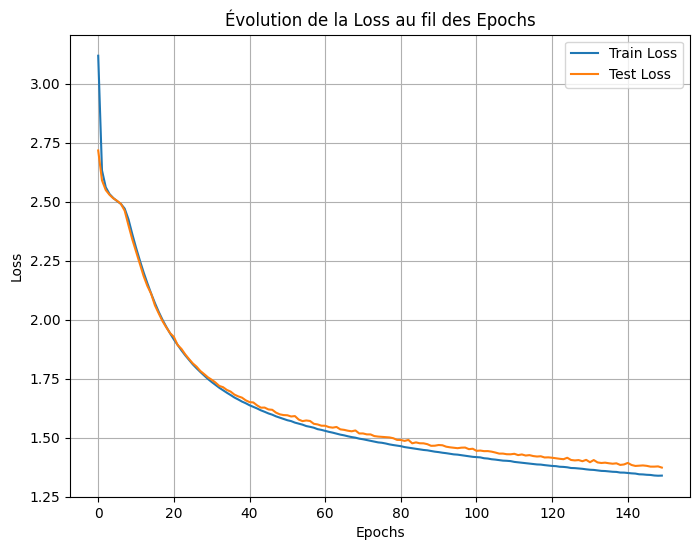

In [ ]:
#Évolution de la Loss au fil des Epochs
plot_loss(train_losses, test_losses)

In [23]:
def generate(model, idx, max_new_tokens):
  # Initialisation de la variable pour stocker l'index du prochain token à prédire
  idx_next = -1
  # Compteur pour limiter le nombre de tokens générés
  i = 0
  while idx_next != token_to_id['<eot>'] and i < max_new_tokens :
    # Récupérer l'index du dernier token dans la séquence d'input
    last_index = idx.shape[1] -1
     # Compléter la séquence d'entrée avec des zéros (padding) pour atteindre la taille de contexte
    idx_cond = torch.cat((idx , torch.zeros(1,(context_size - idx.shape[1]),device=device,dtype=torch.long) ), dim=1)

    logits = model(idx_cond)
    # Récupérer les logits pour le dernier token généré
    logits = logits[:,last_index,:] #(1,Vocab_size)
    # Appliquer softmax pour obtenir les probabilités des tokens suivants
    probs = F.softmax(logits , dim = -1)
     # Sélectionner le prochain token
    idx_next = torch.multinomial(probs, num_samples=1)
    # Ajouter le token prédit à la séquence d'entrée pour la prochaine itération
    idx = torch.cat((idx,idx_next) , dim = 1)

    yield decode([idx_next.item()])

    i+=1
  #return idx

In [32]:

from time import sleep
def tester_le_model(test):
  model.eval()
  # Créer l'ID de la séquence de test en ajoutant le token de début de séquence (<sot>)
  s_id = [token_to_id['<sot>']]  +[token_to_id[char] for char in test]
  s_id = torch.tensor(s_id , dtype=torch.long , device=device)
  # Ajouter une dimension supplémentair
  s_id = s_id.unsqueeze(0)
  print(test,end='')
  #generated_chars = decode(generate(m,s_id, max_new_tokens= context_size - s_id.shape[1] )[0].tolist())
  # Générer les caractères un par un avec la fonction `generate` jusqu'à ce que la longueur maximale soit atteinte
  Prediction = test
  for char in generate(model,s_id, max_new_tokens= context_size - s_id.shape[1] ):
    print(char, end='')
    Prediction = Prediction + char
  return Prediction


  #

In [33]:
test = "Trump"
# tester le model
tester_le_model(test)

'Trump just was today control, like ad many success? Only sink for extrapidaters deadly anyone.<eot>'

In [35]:
predictions = [
    tester_le_model(R[:len(R)//2]) for R in tweets[:10]
]
print("\n\n")
for p in predictions:
  print(p)

# Calcul des scores
bleu_score = compute_bleu(tweets[:10], predictions)

print(f"Score BLEU : {bleu_score:.4f}")




Be sure to tune in and watch Donald Trump on Late Night with Hassamick Amerod. We want handling that Suprement! Kenton pay!<eot>
Donald Trump will be appearing on The View tomorrow morning to disaster. Phill such riquoin or introngest over with apres of every consecials ased bling the spieng about me!<eot>
Miss USA Tara Conner will not be fired - "I've always the reached Granger successasting to some, now, and hold make of for a man!<eot>
Here's to a safe and happy Independence Day and Peting to says of Korea is board football ways share. The are appeale high militarians economically good at NYC, Armendon. Our potest with three economic on debatedy hits as conflict ev Liberama - any very when hit a great and which necesslowed immigrant as actuality in 208 the life.<eot>
Wishing you and yours a very Happy and very able other execut, despite us. Get bleased, have sanced speech can better phony comebablowi Endorsement left, endoval fied D.C. thank EVES!<eot>
Superbowl Sunday is a great

In [36]:
for tweet in tweets[:10]:
  print(tweet[:len(tweet)//2] + "        "+tweet[len(tweet)//2:])

Be sure to tune in and watch Donald Trump on Late Night wi        th David Letterman as he presents the Top Ten List tonight!
Donald Trump will be appearing on The View tomorrow morning to di        scuss Celebrity Apprentice and his new book Think Like A Champion!
Miss USA Tara Conner will not be fired - "I've always         been a believer in second chances." says Donald Trump
Here's to a safe and happy Independence Day         for one and all - Enjoy it! --Donald J. Trump
Wishing you and yours a very Ha        ppy and Bountiful Thanksgiving!
Superbowl Sunday is a great American tradition. The Colts a        nd Saints are already champions, but may the best team win!
The Celebrity Apprentice has a two-hour premiere this Sunday, March 1        4th, at 9 p.m. on NBC. This will be the best season yet, see you then!
The new season of the Celebrity Apprentice is off to a great star        t-- last night it swept the 10 p.m. hour in every key demographic.
Olympic Gold Medalist Evan Lysacek

#Utilisation de SentencePiece comme tokenizer


Dans cette étape, nous utilisons SentencePiece pour tokeniser le texte
à la place des tokenizers classiques basés sur les caractères.
SentencePiece applique un algorithme BPE (Byte-Pair Encoding) pour
segmenter les mots en sous-mots (ou "tokens").
Ce modèle de tokenizer est entraîné sur un corpus de tweets et permet de mieux gérer les mots rares et les nouvelles expressions.


In [37]:
context_size = 512
epochs = 150

In [38]:
!pip install sentencepiece

In [39]:
with open("tweets_corpus.txt", "w", encoding="utf-8") as f:
    for tweet in tweets:
      # Écrire chaque tweet dans le fichier, suivi d'un saut de ligne
        f.write(tweet + "\n")

In [40]:
import sentencepiece as spm

# Entraînement du modèle SentencePiece
spm.SentencePieceTrainer.Train(
    "--input=tweets_corpus.txt --model_prefix=spm --vocab_size=8000 --character_coverage=0.9995 --model_type=bpe"
)

In [41]:
sp = spm.SentencePieceProcessor(model_file="spm.model")

# Exemple de tokenization
text = "This is an example tweet."
tokens = sp.encode(text, out_type=str)  # Liste des tokens sous forme de string
print("Tokens:", tokens)

# Convertir les tokens en IDs
token_ids = sp.encode(text)  # Liste des IDs
print("Token IDs:", token_ids)

# Décoder les tokens en texte
decoded_text = sp.decode(token_ids)
print("Texte décodé:", decoded_text)

Tokens: ['▁This', '▁is', '▁an', '▁example', '▁tweet', '.']
Token IDs: [518, 48, 24, 5668, 6806, 7953]
Texte décodé: This is an example tweet.


In [42]:
for i in range(10):  # Afficher les 10 premiers tokens du vocab
    print(f"{i}: {sp.id_to_piece(i)}")


0: <unk>
1: <s>
2: </s>
3: ▁t
4: ▁a
5: in
6: he
7: re
8: ▁w
9: on


In [43]:
sp.piece_to_id("<s>")
# récupèrer la taille du vocabulaire du modèle SentencePiece
VOCAB_SIZE = sp.get_piece_size()

In [44]:
def data_preprocessing(base) :
  n = len(base)

  code = []
  for s in base :
    # Utiliser SentencePiece pour encoder chaque tweet en ajoutant les tokens de début et de fin de séquence
    # "<s>" pour le début et "</s>" pour la fin de séquence
    s = [sp.piece_to_id("<s>")] + sp.encode(s)  + [sp.piece_to_id("</s>")]
    code.extend(s)
  data = np.asarray(code)
  indices = np.where(data==1)[0]
  return torch.from_numpy(data),indices.astype(int)

In [45]:
data, indices = data_preprocessing(tweets)
print(data)
print(indices)

tensor([   1,  771, 1671,  ..., 4565, 7963,    2])
[     0     31     56 ... 241061 241078 241100]


In [46]:
train_dataloader, test_dataloader = build_dataloader(data,indices, batch_size,context_size)

(xb,yb) = next(iter(train_dataloader))
print(xb)
print(yb)

tensor([[   1, 1966,  151,  ...,   84, 1595,   69],
        [   1,  896, 2430,  ..., 2318,   38, 1079],
        [   1,  289,  856,  ..., 7953, 3634, 7061],
        ...,
        [   1,  909, 7958,  ...,  272,  293, 3447],
        [   1,  569,  673,  ...,   55, 4328, 3453],
        [   1,   40, 3384,  ..., 1396,   32, 7981]])
tensor([[1966,  151,   66,  ..., 1595,   69, 1080],
        [ 896, 2430, 7958,  ...,   38, 1079, 1109],
        [ 289,  856, 2498,  ..., 3634, 7061,   48],
        ...,
        [ 909, 7958,  179,  ...,  293, 3447,   45],
        [ 569,  673, 2147,  ..., 4328, 3453, 7953],
        [  40, 3384, 2636,  ...,   32, 7981, 2685]])


In [47]:
from logging import log

model = Gpt()
model= model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
# Afficher le nombre de paramètres et la structure du réseau
summary(model)

Layer (type:depth-idx)                                       Param #
Gpt                                                          --
├─TokenAndPositionEmbedding: 1-1                             --
│    └─Embedding: 2-1                                        1,200,000
│    └─Embedding: 2-2                                        76,800
├─Sequential: 1-2                                            --
│    └─TransformerBlock: 2-3                                 --
│    │    └─MultiheadAttention: 3-1                          90,600
│    │    └─Sequential: 3-2                                  180,750
│    │    └─LayerNorm: 3-3                                   300
│    │    └─LayerNorm: 3-4                                   300
│    │    └─Dropout: 3-5                                     --
│    │    └─Dropout: 3-6                                     --
│    └─TransformerBlock: 2-4                                 --
│    │    └─MultiheadAttention: 3-7                          90,600
│    │   

In [111]:
if os.path.exists('model_weights/model_with_tokenizer.pth'):
    model.load_state_dict(torch.load('model_weights/model_with_tokenizer.pth'))

<ipython-input-111-0a85ff37465d>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('model_weights/model_with_tokenizer.pth'))


In [48]:
train_losses = []
test_losses = []

for epoch in range(epochs):
    model.train()

    cum_loss_value = 0
    correct_train = 0
    total_train = 0

    for xb, yb in tqdm(train_dataloader):
        xb, yb = xb.to(device), yb.to(device)


        # Calcul de la loss
        logits = model(xb)
        B, T, C = logits.shape
        logits = logits.view(B*T, C)
        yb = yb.view(B*T)
        loss = F.cross_entropy(logits, yb)
        cum_loss_value = cum_loss_value + loss.item()

        # Calcul de l'accuracy sur le train set
        probs = F.softmax(logits , dim = -1)
        preds = torch.argmax(probs, dim=-1)
        correct_train += (preds == yb).sum().item()
        total_train += yb.numel()

        # Backpropagation
        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()

    avg_train_loss = cum_loss_value / len(train_dataloader)
    train_accuracy = correct_train / total_train * 100
    train_losses.append(avg_train_loss)
    # Calcul de la loss et de l'accuracy sur les données de test
    avg_test_loss, test_accuracy = validation_data_loss_and_accuracy(model, test_dataloader)
    test_losses.append(avg_test_loss)

    print(f"Epoch {epoch+1}: Train Loss = {avg_train_loss:.4f}, Train Accuracy = {train_accuracy:.2f}% | Test Loss = {avg_test_loss:.4f}, Test Accuracy = {test_accuracy:.2f}%")

100%|██████████| 201/201 [00:28<00:00,  6.98it/s]


Epoch 1: Train Loss = 7.5093, Train Accuracy = 7.55% | Test Loss = 6.6425, Test Accuracy = 11.54%


100%|██████████| 201/201 [00:29<00:00,  6.91it/s]


Epoch 2: Train Loss = 6.1908, Train Accuracy = 14.88% | Test Loss = 5.7812, Test Accuracy = 18.18%


100%|██████████| 201/201 [00:28<00:00,  7.09it/s]


Epoch 3: Train Loss = 5.5025, Train Accuracy = 20.08% | Test Loss = 5.2800, Test Accuracy = 21.40%


100%|██████████| 201/201 [00:28<00:00,  7.05it/s]


Epoch 4: Train Loss = 5.1119, Train Accuracy = 22.43% | Test Loss = 4.9858, Test Accuracy = 22.95%


100%|██████████| 201/201 [00:28<00:00,  7.07it/s]


Epoch 5: Train Loss = 4.8567, Train Accuracy = 23.60% | Test Loss = 4.7708, Test Accuracy = 23.77%


100%|██████████| 201/201 [00:28<00:00,  7.07it/s]


Epoch 6: Train Loss = 4.6610, Train Accuracy = 24.27% | Test Loss = 4.5992, Test Accuracy = 24.38%


100%|██████████| 201/201 [00:28<00:00,  7.08it/s]


Epoch 7: Train Loss = 4.4990, Train Accuracy = 24.75% | Test Loss = 4.4516, Test Accuracy = 24.74%


100%|██████████| 201/201 [00:28<00:00,  7.07it/s]


Epoch 8: Train Loss = 4.3596, Train Accuracy = 25.23% | Test Loss = 4.3246, Test Accuracy = 25.22%


100%|██████████| 201/201 [00:28<00:00,  7.05it/s]


Epoch 9: Train Loss = 4.2342, Train Accuracy = 25.71% | Test Loss = 4.2090, Test Accuracy = 25.69%


100%|██████████| 201/201 [00:28<00:00,  7.06it/s]


Epoch 10: Train Loss = 4.1183, Train Accuracy = 26.28% | Test Loss = 4.1045, Test Accuracy = 26.27%


100%|██████████| 201/201 [00:28<00:00,  7.06it/s]


Epoch 11: Train Loss = 4.0071, Train Accuracy = 27.01% | Test Loss = 3.9943, Test Accuracy = 27.02%


100%|██████████| 201/201 [00:28<00:00,  7.07it/s]


Epoch 12: Train Loss = 3.8949, Train Accuracy = 27.93% | Test Loss = 3.8844, Test Accuracy = 28.00%


100%|██████████| 201/201 [00:28<00:00,  7.05it/s]


Epoch 13: Train Loss = 3.7783, Train Accuracy = 29.16% | Test Loss = 3.7770, Test Accuracy = 29.02%


100%|██████████| 201/201 [00:28<00:00,  7.07it/s]


Epoch 14: Train Loss = 3.6580, Train Accuracy = 30.57% | Test Loss = 3.6641, Test Accuracy = 30.72%


100%|██████████| 201/201 [00:28<00:00,  7.05it/s]


Epoch 15: Train Loss = 3.5340, Train Accuracy = 32.21% | Test Loss = 3.5399, Test Accuracy = 32.06%


100%|██████████| 201/201 [00:28<00:00,  7.06it/s]


Epoch 16: Train Loss = 3.4056, Train Accuracy = 33.99% | Test Loss = 3.4214, Test Accuracy = 34.01%


100%|██████████| 201/201 [00:28<00:00,  7.08it/s]


Epoch 17: Train Loss = 3.2748, Train Accuracy = 35.95% | Test Loss = 3.2956, Test Accuracy = 35.88%


100%|██████████| 201/201 [00:28<00:00,  7.07it/s]


Epoch 18: Train Loss = 3.1426, Train Accuracy = 38.02% | Test Loss = 3.1732, Test Accuracy = 37.75%


100%|██████████| 201/201 [00:28<00:00,  7.07it/s]


Epoch 19: Train Loss = 3.0103, Train Accuracy = 40.18% | Test Loss = 3.0439, Test Accuracy = 39.72%


100%|██████████| 201/201 [00:28<00:00,  7.08it/s]


Epoch 20: Train Loss = 2.8746, Train Accuracy = 42.49% | Test Loss = 2.9178, Test Accuracy = 42.04%


100%|██████████| 201/201 [00:28<00:00,  7.07it/s]


Epoch 21: Train Loss = 2.7434, Train Accuracy = 44.73% | Test Loss = 2.7907, Test Accuracy = 43.80%


100%|██████████| 201/201 [00:28<00:00,  7.07it/s]


Epoch 22: Train Loss = 2.6117, Train Accuracy = 47.07% | Test Loss = 2.6725, Test Accuracy = 46.06%


100%|██████████| 201/201 [00:28<00:00,  7.07it/s]


Epoch 23: Train Loss = 2.4802, Train Accuracy = 49.49% | Test Loss = 2.5434, Test Accuracy = 48.46%


100%|██████████| 201/201 [00:28<00:00,  7.06it/s]


Epoch 24: Train Loss = 2.3565, Train Accuracy = 51.77% | Test Loss = 2.4206, Test Accuracy = 50.73%


100%|██████████| 201/201 [00:28<00:00,  7.06it/s]


Epoch 25: Train Loss = 2.2303, Train Accuracy = 54.19% | Test Loss = 2.3191, Test Accuracy = 52.52%


100%|██████████| 201/201 [00:28<00:00,  7.04it/s]


Epoch 26: Train Loss = 2.1100, Train Accuracy = 56.50% | Test Loss = 2.1991, Test Accuracy = 55.04%


100%|██████████| 201/201 [00:28<00:00,  7.06it/s]


Epoch 27: Train Loss = 1.9946, Train Accuracy = 58.81% | Test Loss = 2.0984, Test Accuracy = 56.71%


100%|██████████| 201/201 [00:28<00:00,  7.06it/s]


Epoch 28: Train Loss = 1.8827, Train Accuracy = 61.10% | Test Loss = 1.9793, Test Accuracy = 59.20%


100%|██████████| 201/201 [00:28<00:00,  7.05it/s]


Epoch 29: Train Loss = 1.7747, Train Accuracy = 63.37% | Test Loss = 1.8777, Test Accuracy = 61.20%


100%|██████████| 201/201 [00:28<00:00,  7.04it/s]


Epoch 30: Train Loss = 1.6725, Train Accuracy = 65.56% | Test Loss = 1.7922, Test Accuracy = 63.28%


100%|██████████| 201/201 [00:28<00:00,  7.04it/s]


Epoch 31: Train Loss = 1.5739, Train Accuracy = 67.66% | Test Loss = 1.6918, Test Accuracy = 65.40%


100%|██████████| 201/201 [00:28<00:00,  7.04it/s]


Epoch 32: Train Loss = 1.4819, Train Accuracy = 69.66% | Test Loss = 1.6070, Test Accuracy = 67.36%


100%|██████████| 201/201 [00:28<00:00,  7.02it/s]


Epoch 33: Train Loss = 1.3913, Train Accuracy = 71.61% | Test Loss = 1.5281, Test Accuracy = 69.17%


100%|██████████| 201/201 [00:28<00:00,  7.04it/s]


Epoch 34: Train Loss = 1.3073, Train Accuracy = 73.51% | Test Loss = 1.4396, Test Accuracy = 70.72%


100%|██████████| 201/201 [00:28<00:00,  7.05it/s]


Epoch 35: Train Loss = 1.2295, Train Accuracy = 75.22% | Test Loss = 1.3709, Test Accuracy = 72.25%


100%|██████████| 201/201 [00:28<00:00,  7.05it/s]


Epoch 36: Train Loss = 1.1545, Train Accuracy = 76.85% | Test Loss = 1.2953, Test Accuracy = 74.08%


100%|██████████| 201/201 [00:28<00:00,  7.05it/s]


Epoch 37: Train Loss = 1.0839, Train Accuracy = 78.42% | Test Loss = 1.2362, Test Accuracy = 75.39%


100%|██████████| 201/201 [00:28<00:00,  7.06it/s]


Epoch 38: Train Loss = 1.0172, Train Accuracy = 79.90% | Test Loss = 1.1714, Test Accuracy = 76.90%


100%|██████████| 201/201 [00:28<00:00,  7.05it/s]


Epoch 39: Train Loss = 0.9579, Train Accuracy = 81.16% | Test Loss = 1.1098, Test Accuracy = 78.14%


100%|██████████| 201/201 [00:28<00:00,  7.07it/s]


Epoch 40: Train Loss = 0.9004, Train Accuracy = 82.42% | Test Loss = 1.0549, Test Accuracy = 79.24%


100%|██████████| 201/201 [00:28<00:00,  7.06it/s]


Epoch 41: Train Loss = 0.8458, Train Accuracy = 83.58% | Test Loss = 1.0087, Test Accuracy = 80.25%


100%|██████████| 201/201 [00:28<00:00,  7.07it/s]


Epoch 42: Train Loss = 0.7973, Train Accuracy = 84.61% | Test Loss = 0.9627, Test Accuracy = 81.45%


100%|██████████| 201/201 [00:28<00:00,  7.05it/s]


Epoch 43: Train Loss = 0.7492, Train Accuracy = 85.64% | Test Loss = 0.9145, Test Accuracy = 82.45%


100%|██████████| 201/201 [00:28<00:00,  7.03it/s]


Epoch 44: Train Loss = 0.7086, Train Accuracy = 86.49% | Test Loss = 0.8748, Test Accuracy = 83.32%


100%|██████████| 201/201 [00:28<00:00,  7.04it/s]


Epoch 45: Train Loss = 0.6667, Train Accuracy = 87.33% | Test Loss = 0.8356, Test Accuracy = 84.09%


100%|██████████| 201/201 [00:28<00:00,  7.08it/s]


Epoch 46: Train Loss = 0.6314, Train Accuracy = 88.05% | Test Loss = 0.8039, Test Accuracy = 84.77%


100%|██████████| 201/201 [00:28<00:00,  7.06it/s]


Epoch 47: Train Loss = 0.5960, Train Accuracy = 88.73% | Test Loss = 0.7676, Test Accuracy = 85.43%


100%|██████████| 201/201 [00:28<00:00,  7.03it/s]


Epoch 48: Train Loss = 0.5645, Train Accuracy = 89.35% | Test Loss = 0.7389, Test Accuracy = 86.08%


100%|██████████| 201/201 [00:28<00:00,  7.07it/s]


Epoch 49: Train Loss = 0.5359, Train Accuracy = 89.86% | Test Loss = 0.7095, Test Accuracy = 86.66%


100%|██████████| 201/201 [00:28<00:00,  7.05it/s]


Epoch 50: Train Loss = 0.5102, Train Accuracy = 90.34% | Test Loss = 0.6861, Test Accuracy = 87.09%


100%|██████████| 201/201 [00:28<00:00,  7.07it/s]


Epoch 51: Train Loss = 0.4846, Train Accuracy = 90.82% | Test Loss = 0.6615, Test Accuracy = 87.61%


100%|██████████| 201/201 [00:28<00:00,  7.07it/s]


Epoch 52: Train Loss = 0.4610, Train Accuracy = 91.25% | Test Loss = 0.6413, Test Accuracy = 87.90%


100%|██████████| 201/201 [00:28<00:00,  7.06it/s]


Epoch 53: Train Loss = 0.4409, Train Accuracy = 91.61% | Test Loss = 0.6328, Test Accuracy = 88.23%


100%|██████████| 201/201 [00:28<00:00,  7.04it/s]


Epoch 54: Train Loss = 0.4215, Train Accuracy = 91.95% | Test Loss = 0.6076, Test Accuracy = 88.68%


100%|██████████| 201/201 [00:28<00:00,  7.04it/s]


Epoch 55: Train Loss = 0.4030, Train Accuracy = 92.28% | Test Loss = 0.5855, Test Accuracy = 88.99%


100%|██████████| 201/201 [00:28<00:00,  7.04it/s]


Epoch 56: Train Loss = 0.3865, Train Accuracy = 92.57% | Test Loss = 0.5854, Test Accuracy = 89.06%


100%|██████████| 201/201 [00:28<00:00,  7.04it/s]


Epoch 57: Train Loss = 0.3717, Train Accuracy = 92.82% | Test Loss = 0.5655, Test Accuracy = 89.35%


100%|██████████| 201/201 [00:28<00:00,  7.04it/s]


Epoch 58: Train Loss = 0.3547, Train Accuracy = 93.14% | Test Loss = 0.5535, Test Accuracy = 89.72%


100%|██████████| 201/201 [00:28<00:00,  7.05it/s]


Epoch 59: Train Loss = 0.3427, Train Accuracy = 93.32% | Test Loss = 0.5414, Test Accuracy = 89.88%


100%|██████████| 201/201 [00:28<00:00,  7.06it/s]


Epoch 60: Train Loss = 0.3308, Train Accuracy = 93.52% | Test Loss = 0.5326, Test Accuracy = 90.07%


100%|██████████| 201/201 [00:28<00:00,  7.04it/s]


Epoch 61: Train Loss = 0.3187, Train Accuracy = 93.73% | Test Loss = 0.5207, Test Accuracy = 90.26%


100%|██████████| 201/201 [00:28<00:00,  7.04it/s]


Epoch 62: Train Loss = 0.3075, Train Accuracy = 93.92% | Test Loss = 0.5180, Test Accuracy = 90.33%


100%|██████████| 201/201 [00:28<00:00,  7.04it/s]


Epoch 63: Train Loss = 0.2996, Train Accuracy = 94.05% | Test Loss = 0.5080, Test Accuracy = 90.49%


100%|██████████| 201/201 [00:28<00:00,  7.04it/s]


Epoch 64: Train Loss = 0.2872, Train Accuracy = 94.28% | Test Loss = 0.5012, Test Accuracy = 90.70%


100%|██████████| 201/201 [00:28<00:00,  7.03it/s]


Epoch 65: Train Loss = 0.2789, Train Accuracy = 94.41% | Test Loss = 0.4961, Test Accuracy = 90.77%


100%|██████████| 201/201 [00:28<00:00,  7.04it/s]


Epoch 66: Train Loss = 0.2729, Train Accuracy = 94.50% | Test Loss = 0.4898, Test Accuracy = 90.89%


100%|██████████| 201/201 [00:28<00:00,  7.03it/s]


Epoch 67: Train Loss = 0.2637, Train Accuracy = 94.67% | Test Loss = 0.4859, Test Accuracy = 90.97%


100%|██████████| 201/201 [00:28<00:00,  7.04it/s]


Epoch 68: Train Loss = 0.2565, Train Accuracy = 94.79% | Test Loss = 0.4825, Test Accuracy = 91.06%


100%|██████████| 201/201 [00:28<00:00,  7.04it/s]


Epoch 69: Train Loss = 0.2486, Train Accuracy = 94.93% | Test Loss = 0.4785, Test Accuracy = 91.12%


100%|██████████| 201/201 [00:28<00:00,  7.04it/s]


Epoch 70: Train Loss = 0.2434, Train Accuracy = 95.01% | Test Loss = 0.4751, Test Accuracy = 91.25%


100%|██████████| 201/201 [00:28<00:00,  7.05it/s]


Epoch 71: Train Loss = 0.2368, Train Accuracy = 95.14% | Test Loss = 0.4648, Test Accuracy = 91.34%


100%|██████████| 201/201 [00:28<00:00,  7.06it/s]


Epoch 72: Train Loss = 0.2327, Train Accuracy = 95.20% | Test Loss = 0.4598, Test Accuracy = 91.43%


100%|██████████| 201/201 [00:28<00:00,  7.07it/s]


Epoch 73: Train Loss = 0.2247, Train Accuracy = 95.36% | Test Loss = 0.4608, Test Accuracy = 91.56%


100%|██████████| 201/201 [00:28<00:00,  7.03it/s]


Epoch 74: Train Loss = 0.2164, Train Accuracy = 95.53% | Test Loss = 0.4556, Test Accuracy = 91.66%


100%|██████████| 201/201 [00:28<00:00,  7.07it/s]


Epoch 75: Train Loss = 0.2133, Train Accuracy = 95.57% | Test Loss = 0.4609, Test Accuracy = 91.62%


100%|██████████| 201/201 [00:28<00:00,  7.08it/s]


Epoch 76: Train Loss = 0.2099, Train Accuracy = 95.63% | Test Loss = 0.4510, Test Accuracy = 91.75%


100%|██████████| 201/201 [00:28<00:00,  7.04it/s]


Epoch 77: Train Loss = 0.2030, Train Accuracy = 95.78% | Test Loss = 0.4531, Test Accuracy = 91.81%


100%|██████████| 201/201 [00:28<00:00,  7.03it/s]


Epoch 78: Train Loss = 0.1986, Train Accuracy = 95.85% | Test Loss = 0.4466, Test Accuracy = 91.83%


100%|██████████| 201/201 [00:28<00:00,  7.05it/s]


Epoch 79: Train Loss = 0.1965, Train Accuracy = 95.88% | Test Loss = 0.4497, Test Accuracy = 91.80%


100%|██████████| 201/201 [00:28<00:00,  7.04it/s]


Epoch 80: Train Loss = 0.1919, Train Accuracy = 95.97% | Test Loss = 0.4440, Test Accuracy = 92.00%


100%|██████████| 201/201 [00:28<00:00,  7.05it/s]


Epoch 81: Train Loss = 0.1872, Train Accuracy = 96.07% | Test Loss = 0.4460, Test Accuracy = 91.93%


100%|██████████| 201/201 [00:28<00:00,  7.06it/s]


Epoch 82: Train Loss = 0.1845, Train Accuracy = 96.11% | Test Loss = 0.4455, Test Accuracy = 92.02%


100%|██████████| 201/201 [00:28<00:00,  7.08it/s]


Epoch 83: Train Loss = 0.1787, Train Accuracy = 96.23% | Test Loss = 0.4402, Test Accuracy = 92.14%


100%|██████████| 201/201 [00:28<00:00,  7.08it/s]


Epoch 84: Train Loss = 0.1745, Train Accuracy = 96.31% | Test Loss = 0.4462, Test Accuracy = 92.01%


100%|██████████| 201/201 [00:28<00:00,  7.08it/s]


Epoch 85: Train Loss = 0.1728, Train Accuracy = 96.34% | Test Loss = 0.4503, Test Accuracy = 92.11%


100%|██████████| 201/201 [00:28<00:00,  7.08it/s]


Epoch 86: Train Loss = 0.1710, Train Accuracy = 96.36% | Test Loss = 0.4363, Test Accuracy = 92.24%


100%|██████████| 201/201 [00:28<00:00,  7.08it/s]


Epoch 87: Train Loss = 0.1646, Train Accuracy = 96.51% | Test Loss = 0.4399, Test Accuracy = 92.32%


100%|██████████| 201/201 [00:28<00:00,  7.04it/s]


Epoch 88: Train Loss = 0.1601, Train Accuracy = 96.60% | Test Loss = 0.4371, Test Accuracy = 92.28%


100%|██████████| 201/201 [00:28<00:00,  7.04it/s]


Epoch 89: Train Loss = 0.1587, Train Accuracy = 96.62% | Test Loss = 0.4492, Test Accuracy = 92.26%


100%|██████████| 201/201 [00:28<00:00,  7.05it/s]


Epoch 90: Train Loss = 0.1583, Train Accuracy = 96.62% | Test Loss = 0.4437, Test Accuracy = 92.31%


100%|██████████| 201/201 [00:28<00:00,  7.04it/s]


Epoch 91: Train Loss = 0.1559, Train Accuracy = 96.66% | Test Loss = 0.4395, Test Accuracy = 92.44%


100%|██████████| 201/201 [00:28<00:00,  7.06it/s]


Epoch 92: Train Loss = 0.1515, Train Accuracy = 96.77% | Test Loss = 0.4400, Test Accuracy = 92.44%


100%|██████████| 201/201 [00:28<00:00,  7.04it/s]


Epoch 93: Train Loss = 0.1474, Train Accuracy = 96.86% | Test Loss = 0.4340, Test Accuracy = 92.53%


100%|██████████| 201/201 [00:28<00:00,  7.06it/s]


Epoch 94: Train Loss = 0.1448, Train Accuracy = 96.91% | Test Loss = 0.4344, Test Accuracy = 92.54%


100%|██████████| 201/201 [00:28<00:00,  7.03it/s]


Epoch 95: Train Loss = 0.1410, Train Accuracy = 96.99% | Test Loss = 0.4336, Test Accuracy = 92.58%


100%|██████████| 201/201 [00:28<00:00,  7.04it/s]


Epoch 96: Train Loss = 0.1396, Train Accuracy = 97.02% | Test Loss = 0.4388, Test Accuracy = 92.54%


100%|██████████| 201/201 [00:28<00:00,  7.03it/s]


Epoch 97: Train Loss = 0.1379, Train Accuracy = 97.05% | Test Loss = 0.4414, Test Accuracy = 92.59%


100%|██████████| 201/201 [00:28<00:00,  7.05it/s]


Epoch 98: Train Loss = 0.1368, Train Accuracy = 97.07% | Test Loss = 0.4389, Test Accuracy = 92.62%


100%|██████████| 201/201 [00:28<00:00,  7.05it/s]


Epoch 99: Train Loss = 0.1352, Train Accuracy = 97.09% | Test Loss = 0.4410, Test Accuracy = 92.64%


100%|██████████| 201/201 [00:28<00:00,  7.04it/s]


Epoch 100: Train Loss = 0.1331, Train Accuracy = 97.14% | Test Loss = 0.4460, Test Accuracy = 92.64%


100%|██████████| 201/201 [00:28<00:00,  7.05it/s]


Epoch 101: Train Loss = 0.1296, Train Accuracy = 97.22% | Test Loss = 0.4437, Test Accuracy = 92.73%


100%|██████████| 201/201 [00:28<00:00,  7.04it/s]


Epoch 102: Train Loss = 0.1258, Train Accuracy = 97.31% | Test Loss = 0.4316, Test Accuracy = 92.76%


100%|██████████| 201/201 [00:28<00:00,  7.03it/s]


Epoch 103: Train Loss = 0.1253, Train Accuracy = 97.31% | Test Loss = 0.4446, Test Accuracy = 92.71%


100%|██████████| 201/201 [00:28<00:00,  7.05it/s]


Epoch 104: Train Loss = 0.1263, Train Accuracy = 97.27% | Test Loss = 0.4512, Test Accuracy = 92.66%


100%|██████████| 201/201 [00:28<00:00,  7.07it/s]


Epoch 105: Train Loss = 0.1270, Train Accuracy = 97.25% | Test Loss = 0.4425, Test Accuracy = 92.83%


100%|██████████| 201/201 [00:28<00:00,  7.06it/s]


Epoch 106: Train Loss = 0.1166, Train Accuracy = 97.50% | Test Loss = 0.4365, Test Accuracy = 93.00%


100%|██████████| 201/201 [00:28<00:00,  7.04it/s]


Epoch 107: Train Loss = 0.1127, Train Accuracy = 97.60% | Test Loss = 0.4353, Test Accuracy = 92.97%


100%|██████████| 201/201 [00:28<00:00,  7.05it/s]


Epoch 108: Train Loss = 0.1123, Train Accuracy = 97.60% | Test Loss = 0.4370, Test Accuracy = 92.94%


100%|██████████| 201/201 [00:28<00:00,  7.05it/s]


Epoch 109: Train Loss = 0.1151, Train Accuracy = 97.52% | Test Loss = 0.4479, Test Accuracy = 92.79%


100%|██████████| 201/201 [00:28<00:00,  7.05it/s]


Epoch 110: Train Loss = 0.1240, Train Accuracy = 97.26% | Test Loss = 0.4428, Test Accuracy = 92.73%


100%|██████████| 201/201 [00:28<00:00,  7.04it/s]


Epoch 111: Train Loss = 0.1137, Train Accuracy = 97.52% | Test Loss = 0.4398, Test Accuracy = 93.00%


100%|██████████| 201/201 [00:28<00:00,  7.05it/s]


Epoch 112: Train Loss = 0.1054, Train Accuracy = 97.74% | Test Loss = 0.4355, Test Accuracy = 93.16%


100%|██████████| 201/201 [00:28<00:00,  7.04it/s]


Epoch 113: Train Loss = 0.1010, Train Accuracy = 97.86% | Test Loss = 0.4400, Test Accuracy = 93.16%


100%|██████████| 201/201 [00:28<00:00,  7.03it/s]


Epoch 114: Train Loss = 0.1028, Train Accuracy = 97.80% | Test Loss = 0.4559, Test Accuracy = 92.98%


100%|██████████| 201/201 [00:28<00:00,  7.04it/s]


Epoch 115: Train Loss = 0.1102, Train Accuracy = 97.60% | Test Loss = 0.4563, Test Accuracy = 92.82%


100%|██████████| 201/201 [00:28<00:00,  7.05it/s]


Epoch 116: Train Loss = 0.1122, Train Accuracy = 97.54% | Test Loss = 0.4438, Test Accuracy = 93.05%


100%|██████████| 201/201 [00:28<00:00,  7.04it/s]


Epoch 117: Train Loss = 0.1021, Train Accuracy = 97.79% | Test Loss = 0.4369, Test Accuracy = 93.17%


100%|██████████| 201/201 [00:28<00:00,  7.04it/s]


Epoch 118: Train Loss = 0.0971, Train Accuracy = 97.92% | Test Loss = 0.4437, Test Accuracy = 93.20%


100%|██████████| 201/201 [00:28<00:00,  7.04it/s]


Epoch 119: Train Loss = 0.0957, Train Accuracy = 97.95% | Test Loss = 0.4503, Test Accuracy = 93.15%


100%|██████████| 201/201 [00:28<00:00,  7.03it/s]


Epoch 120: Train Loss = 0.0960, Train Accuracy = 97.95% | Test Loss = 0.4508, Test Accuracy = 93.15%


100%|██████████| 201/201 [00:28<00:00,  7.04it/s]


Epoch 121: Train Loss = 0.0975, Train Accuracy = 97.90% | Test Loss = 0.4485, Test Accuracy = 93.14%


100%|██████████| 201/201 [00:28<00:00,  7.04it/s]


Epoch 122: Train Loss = 0.0998, Train Accuracy = 97.82% | Test Loss = 0.4471, Test Accuracy = 93.11%


100%|██████████| 201/201 [00:28<00:00,  7.03it/s]


Epoch 123: Train Loss = 0.0978, Train Accuracy = 97.87% | Test Loss = 0.4507, Test Accuracy = 93.22%


100%|██████████| 201/201 [00:28<00:00,  7.05it/s]


Epoch 124: Train Loss = 0.0925, Train Accuracy = 98.01% | Test Loss = 0.4491, Test Accuracy = 93.28%


100%|██████████| 201/201 [00:28<00:00,  7.04it/s]


Epoch 125: Train Loss = 0.0890, Train Accuracy = 98.09% | Test Loss = 0.4528, Test Accuracy = 93.27%


100%|██████████| 201/201 [00:28<00:00,  7.05it/s]


Epoch 126: Train Loss = 0.0889, Train Accuracy = 98.10% | Test Loss = 0.4447, Test Accuracy = 93.27%


100%|██████████| 201/201 [00:28<00:00,  7.05it/s]


Epoch 127: Train Loss = 0.0895, Train Accuracy = 98.07% | Test Loss = 0.4539, Test Accuracy = 93.25%


100%|██████████| 201/201 [00:28<00:00,  7.04it/s]


Epoch 128: Train Loss = 0.0886, Train Accuracy = 98.09% | Test Loss = 0.4545, Test Accuracy = 93.29%


100%|██████████| 201/201 [00:28<00:00,  7.06it/s]


Epoch 129: Train Loss = 0.0904, Train Accuracy = 98.03% | Test Loss = 0.4595, Test Accuracy = 93.13%


100%|██████████| 201/201 [00:28<00:00,  7.06it/s]


Epoch 130: Train Loss = 0.0913, Train Accuracy = 98.00% | Test Loss = 0.4565, Test Accuracy = 93.29%


100%|██████████| 201/201 [00:28<00:00,  7.07it/s]


Epoch 131: Train Loss = 0.0852, Train Accuracy = 98.16% | Test Loss = 0.4496, Test Accuracy = 93.43%


100%|██████████| 201/201 [00:28<00:00,  7.05it/s]


Epoch 132: Train Loss = 0.0814, Train Accuracy = 98.26% | Test Loss = 0.4537, Test Accuracy = 93.43%


100%|██████████| 201/201 [00:28<00:00,  7.04it/s]


Epoch 133: Train Loss = 0.0798, Train Accuracy = 98.29% | Test Loss = 0.4554, Test Accuracy = 93.43%


100%|██████████| 201/201 [00:28<00:00,  7.08it/s]


Epoch 134: Train Loss = 0.0792, Train Accuracy = 98.30% | Test Loss = 0.4653, Test Accuracy = 93.35%


100%|██████████| 201/201 [00:28<00:00,  7.08it/s]


Epoch 135: Train Loss = 0.0836, Train Accuracy = 98.19% | Test Loss = 0.4647, Test Accuracy = 93.26%


100%|██████████| 201/201 [00:28<00:00,  7.06it/s]


Epoch 136: Train Loss = 0.0884, Train Accuracy = 98.05% | Test Loss = 0.4590, Test Accuracy = 93.25%


100%|██████████| 201/201 [00:28<00:00,  7.08it/s]


Epoch 137: Train Loss = 0.0840, Train Accuracy = 98.16% | Test Loss = 0.4621, Test Accuracy = 93.44%


100%|██████████| 201/201 [00:28<00:00,  7.07it/s]


Epoch 138: Train Loss = 0.0766, Train Accuracy = 98.35% | Test Loss = 0.4522, Test Accuracy = 93.56%


100%|██████████| 201/201 [00:28<00:00,  7.08it/s]


Epoch 139: Train Loss = 0.0732, Train Accuracy = 98.44% | Test Loss = 0.4670, Test Accuracy = 93.55%


100%|██████████| 201/201 [00:28<00:00,  7.08it/s]


Epoch 140: Train Loss = 0.0729, Train Accuracy = 98.44% | Test Loss = 0.4602, Test Accuracy = 93.50%


100%|██████████| 201/201 [00:28<00:00,  7.08it/s]


Epoch 141: Train Loss = 0.0755, Train Accuracy = 98.37% | Test Loss = 0.4720, Test Accuracy = 93.35%


100%|██████████| 201/201 [00:28<00:00,  7.07it/s]


Epoch 142: Train Loss = 0.0825, Train Accuracy = 98.17% | Test Loss = 0.4703, Test Accuracy = 93.31%


100%|██████████| 201/201 [00:28<00:00,  7.06it/s]


Epoch 143: Train Loss = 0.0805, Train Accuracy = 98.22% | Test Loss = 0.4639, Test Accuracy = 93.47%


100%|██████████| 201/201 [00:28<00:00,  7.07it/s]


Epoch 144: Train Loss = 0.0738, Train Accuracy = 98.40% | Test Loss = 0.4642, Test Accuracy = 93.62%


100%|██████████| 201/201 [00:28<00:00,  7.05it/s]


Epoch 145: Train Loss = 0.0684, Train Accuracy = 98.53% | Test Loss = 0.4650, Test Accuracy = 93.65%


100%|██████████| 201/201 [00:28<00:00,  7.05it/s]


Epoch 146: Train Loss = 0.0660, Train Accuracy = 98.60% | Test Loss = 0.4660, Test Accuracy = 93.64%


100%|██████████| 201/201 [00:28<00:00,  7.04it/s]


Epoch 147: Train Loss = 0.0668, Train Accuracy = 98.58% | Test Loss = 0.4760, Test Accuracy = 93.50%


100%|██████████| 201/201 [00:28<00:00,  7.03it/s]


Epoch 148: Train Loss = 0.0736, Train Accuracy = 98.40% | Test Loss = 0.4866, Test Accuracy = 93.22%


100%|██████████| 201/201 [00:28<00:00,  7.02it/s]


Epoch 149: Train Loss = 0.0894, Train Accuracy = 97.94% | Test Loss = 0.4801, Test Accuracy = 93.18%


100%|██████████| 201/201 [00:28<00:00,  7.01it/s]


Epoch 150: Train Loss = 0.0754, Train Accuracy = 98.32% | Test Loss = 0.4591, Test Accuracy = 93.70%


In [49]:
os.makedirs('model_weights', exist_ok=True)
torch.save(model.state_dict(), 'model_weights/model_with_tokenizer.pth')

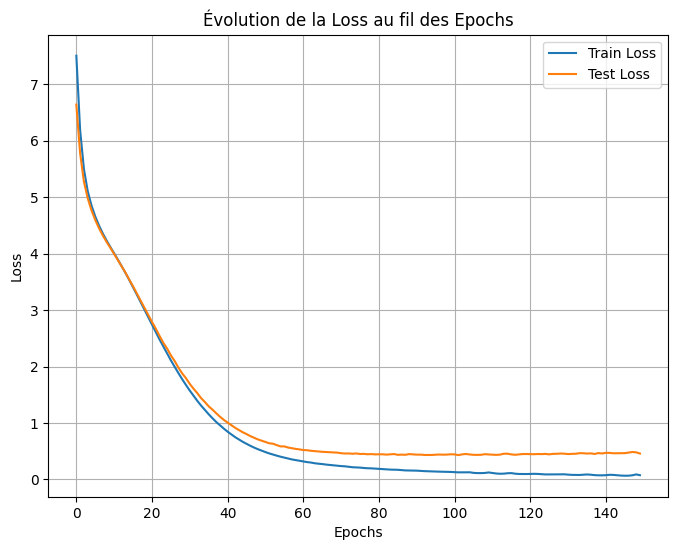

In [50]:
#Évolution de la Loss au fil des Epochs
plot_loss(train_losses, test_losses)

In [51]:
def generate(model, idx, max_new_tokens, temperature=1.0):

  idx_next = -1
  i = 0
  while idx_next != sp.piece_to_id("</s>") and i < max_new_tokens :

    last_index = idx.shape[1] -1

    idx_cond = torch.cat((idx , torch.zeros(1,(context_size - idx.shape[1]),device=device,dtype=torch.long) ), dim=1)

    logits = model(idx_cond)
    logits = logits[:,last_index,:]
    probs = F.softmax(logits , dim = -1)
    idx_next = torch.multinomial(probs, num_samples=1)

    idx = torch.cat((idx,idx_next) , dim = 1)

    text = sp.decode(idx.tolist())[0].split(" ") [-1]
    yield text

    i+=1
  #return idx

In [52]:
def clean_output(text):
    return text.replace('▁', ' ')

In [92]:
from time import sleep
def tester_le_model3(test):
  model.eval()

  s_id =[sp.piece_to_id("<s>")] + sp.encode(test)
  s_id = torch.tensor(s_id , dtype=torch.long , device=device)
  s_id = s_id.unsqueeze(0)
  print(test,end='')
  #generated_chars = decode(generate(m,s_id, max_new_tokens= context_size - s_id.shape[1] )[0].tolist())
  Prediction = test
  for char in generate(model,s_id, max_new_tokens= context_size - s_id.shape[1] ):
    print(char, end=' ')
    Prediction = Prediction + char[:-2] + " "
  return Prediction

In [138]:
tester_le_model3("I am happy to announce that the original Apprentice is coming back ")

I am happy to announce that the original Apprentice is coming back back... back... 

'I am happy to announce that the original Apprentice is coming back back. back. '

In [131]:
predictions = [
    tester_le_model3(R[:len(R)//2]) for R in tweets[:10]
]
print("\n\n")
for p in predictions:
  print(p)

# Calcul des scores
bleu_score = compute_bleu(tweets[:10], predictions)

print(f"Score BLEU : {bleu_score:.4f}")

Be sure to tune in and watch Donald Trump on Late Night wiwi. The only to see 12 people doing well and congrats course course, but for two great state state. state. Donald Trump will be appearing on The View tomorrow morning to didij dijun L Les Les. I I. It It' It's been wasted billions billions. billions. Miss USA Tara Conner will not be fired - "I've alwaysliked Ell Ell5 10 p p. p.m p.m. This is a chance - " "I just in n nic nic." -- Winston Churchill Churchill Here's to a safe and happy Independence Day Day. Does anyone think anger and all out of our president president. president. Wishing you and yours a very HaHaven people people. people. Superbowl Sunday is a great American tradition. The Colts aLas Vegas Vegas, Obamacare should cancel it it' it's it's' it's's ratings 10 p pess working with Miss USA A TOTAL magazine magazine.... magazine.... The Celebrity Apprentice has a two-hour premiere this Sunday, March 1sw swapp and all of the great start start. We Wear meeting meeting. Th

In [132]:
for tweet in tweets[:10]:
  print(tweet[:len(tweet)//2] + "        "+tweet[len(tweet)//2:])

Be sure to tune in and watch Donald Trump on Late Night wi        th David Letterman as he presents the Top Ten List tonight!
Donald Trump will be appearing on The View tomorrow morning to di        scuss Celebrity Apprentice and his new book Think Like A Champion!
Miss USA Tara Conner will not be fired - "I've always         been a believer in second chances." says Donald Trump
Here's to a safe and happy Independence Day         for one and all - Enjoy it! --Donald J. Trump
Wishing you and yours a very Ha        ppy and Bountiful Thanksgiving!
Superbowl Sunday is a great American tradition. The Colts a        nd Saints are already champions, but may the best team win!
The Celebrity Apprentice has a two-hour premiere this Sunday, March 1        4th, at 9 p.m. on NBC. This will be the best season yet, see you then!
The new season of the Celebrity Apprentice is off to a great star        t-- last night it swept the 10 p.m. hour in every key demographic.
Olympic Gold Medalist Evan Lysacek